# Model to test deploying to fastapi

In [1]:
# Imports
import datetime as dt
from pathlib import Path

import joblib
import pandas as pd
import yfinance as yf
from fbprophet import Prophet

In [2]:
# Setting base directory and the current date
# DIR = Path(__file__).resolve(strict = True).parent

DIR = Path("main.py").resolve(strict=True).parent

TODAY = dt.date.today()

In [3]:
# Training function for tickers


def train(ticker):

    # Need conditional try/except here for impossible ticker????
    # Also look at dynamic date range up to a few yrs?? Need to time runs with large datasets
    # , and also yfinance API limits. 
    
    data = yf.download(ticker, "2020-01-01", TODAY.strftime("%Y-%m-%d"))
    data.head()
    data["Adj Close"].plot(title=f"{ticker} Stock Adjusted Closing Price")

    df_forecast = data.copy()
    df_forecast.reset_index(inplace=True)
    df_forecast["ds"] = df_forecast["Date"]
    df_forecast["y"] = df_forecast["Adj Close"]
    df_forecast = df_forecast[["ds", "y"]]

    # Check Prophet docs to see how calculated and seasonality args
    model = Prophet()
    model.fit(df_forecast)

    joblib.dump(model, Path(DIR).joinpath(f"{ticker}.joblib"))

[*********************100%***********************]  1 of 1 completed


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


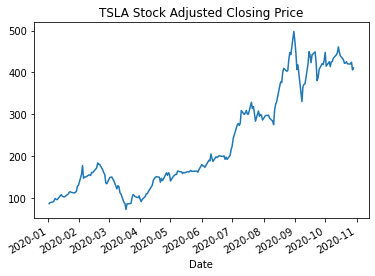

In [4]:
train('TSLA')

In [5]:
# Prediction function

def predict(ticker, days = 7):
    
    ticker_file = Path(DIR).joinpath(f'{ticker}.joblib')
    
    if not ticker_file.exists():
        return False
    
    model = joblib.load(ticker_file)
    
    future = TODAY + dt.timedelta(days = days)
    
    
    # Look at adjusting for training with dynamic range in train and predict functions.
    dates = pd.date_range(start = '2020-01-01', end = future.strftime('%m/%d/%Y'))
    
    df = pd.DataFrame({'ds': dates})
    
    forecast = model.predict(df)
    
    # Need to adjust the graphs to reflect legend with what the lines and price points are.s
    model.plot(forecast).savefig(f'{ticker}_plot.png')
    model.plot_components(forecast).savefig(f'{ticker}_plot_components.png')
    
    return forecast.tail(days).to_dict('records')   
    
    

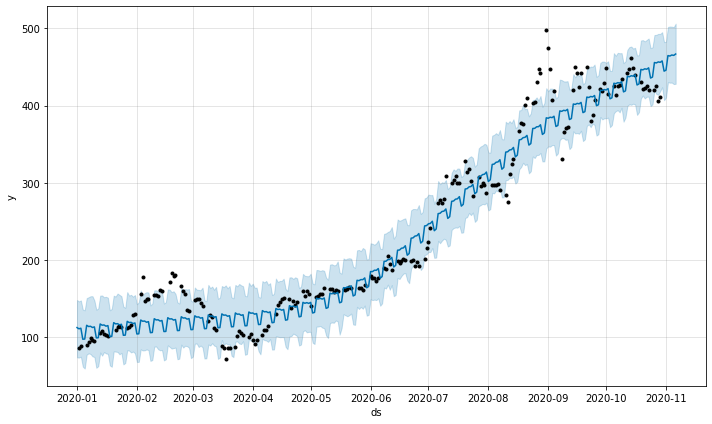

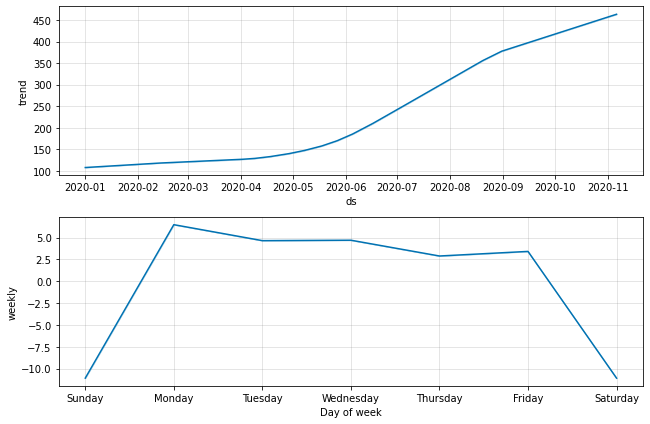

In [6]:
# Set preditction_list output to predict function output to pass to convert function
prediction_list = predict('TSLA')

In [7]:
def convert(prediction_list):
    
    output = {}
    
    for data in prediction_list:
        date = data['ds'].strftime('%m/%d/%Y')
        output[date] = data['trend']
    
    return output

In [8]:
convert(prediction_list)

{'10/31/2020': 455.5955136576696,
 '11/01/2020': 456.8743328861808,
 '11/02/2020': 458.1531521146922,
 '11/03/2020': 459.43197134320343,
 '11/04/2020': 460.71079057171465,
 '11/05/2020': 461.989609800226,
 '11/06/2020': 463.2684290287372}